In [86]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal


class PPO(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.9,
        batch_size=128,
        epsilon=0.2,
        epoch_n=30,
        pi_lr=1e-4,
        v_lr=5e-4,
    ):
        super().__init__()

        self.pi_model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * action_dim),
            nn.Tanh(),
        )

        self.v_model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        states, actions, rewards, dones = map(
            np.array, [states, actions, rewards, dones]
        )
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i : i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = b_returns.detach() - self.v_model(b_states)

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = (
                    torch.clamp(b_ratio, 1.0 - self.epsilon, 1.0 + self.epsilon)
                    * b_advantage.detach()
                )
                pi_loss = -torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage**2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

rewards: -1517.158033784492
rewards: -1358.1529433389956
rewards: -1303.1031067146794
rewards: -1146.0392497314654
rewards: -1021.1648950552795
rewards: -851.9116500603908
rewards: -829.5186514445111
rewards: -796.9589102713151
rewards: -583.3665811006024
rewards: -479.55677968922083


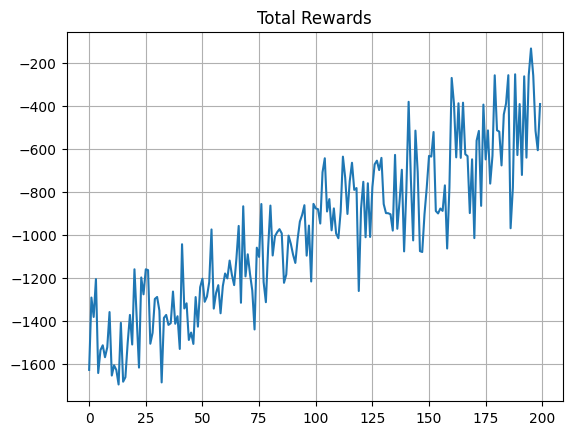

In [87]:
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)

episode_n = 10
trajectory_n = 20

total_rewards = []

for episode in range(episode_n):
    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state, _ = env.reset()
        for t in range(200):
            states.append(state)

            action = agent.get_action(state)
            actions.append(action)

            state, reward, done, _, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)

    agent.fit(states, actions, rewards, dones)
    print(f"rewards: {np.mean(total_rewards[-trajectory_n:])}")

plt.plot(total_rewards)
plt.title("Total Rewards")
plt.grid()
plt.show()

In [93]:
for _ in range(trajectory_n):
    total_reward = 0

    state, _ = env.reset()
    for t in range(200):
        states.append(state)

        action = agent.get_action(state)
        actions.append(action)

        state, reward, done, _, _ = env.step(2 * action)
        rewards.append(reward)
        dones.append(done)

        total_reward += reward

    total_rewards.append(total_reward)

print(f"rewards: {np.mean(total_rewards[-trajectory_n:])}")

rewards: -404.3969002632673
